In [ ]:
!pip install pennylane > h

**Exercise 1**

In the example shown in the slides, we have tried to find the maximum energy value of the Hamiltonian:

```python
H = 0.1 * qml.PauliZ(0) - 2 qml.PauliZ(0) @ qml.PauliZ(1)
```

For this, we have used the parameters:

```python
gammas = [0.3, 0.4]
betas = [0.2, 0.4]
```

Although we have previously obtained good results, there is still room for improvement. Perform a variational algorithm that finds the best `gammas`and `betas` parameters.

**Solution 1**.

First let's show the QAOA structure as seen:

<BarContainer object of 4 artists>

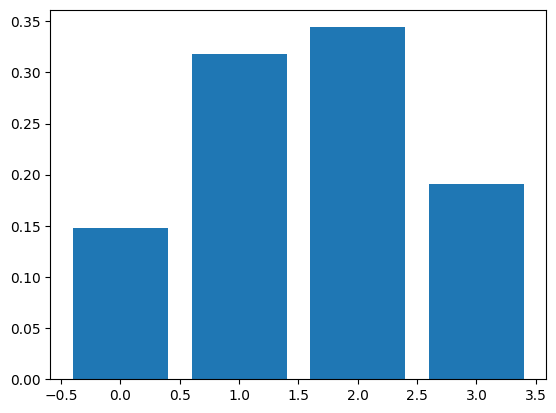

In [ ]:
import pennylane as qml
import matplotlib.pyplot as plt

H = 0.1 * qml.PauliZ(0) - 2 * qml.PauliZ(1) @ qml.PauliZ(0)

def exp(H, gamma):
  qml.ApproxTimeEvolution(H, gamma, n = 1)


def mixer(beta, wires):
  for i in range(len(wires)):
    qml.RX(2*beta, wires = wires[i])

gammas = [0.3, 0.4]
betas = [0.2, 0.4]

dev = qml.device("default.qubit", wires = [0,1])

@qml.qnode(dev)
def qaoa(H, gammas, betas):

  for i in range(2):
    qml.Hadamard(wires = i)

  for gamma, beta in zip(gammas, betas):
    exp(H, gamma)
    mixer(beta, wires = [0,1])

  return qml.probs(wires = [0,1])

output = qaoa(H, gammas, betas)
plt.bar(range(len(output)), output)


Now we have to train the gamma and beta parameters to improve the solution.

In [ ]:
def value_solution(params):

  gammas = params[0:2]
  betas = params[2:]

  @qml.qnode(dev)
  def qaoa(H, gammas, betas):

    for i in range(2):
      qml.Hadamard(wires = i)

    for gamma, beta in zip(gammas, betas):
      exp(H, gamma)
      mixer(beta, wires = [0,1])

    return qml.expval(H)

  return qaoa(H, gammas, betas)



In [ ]:
from scipy.optimize import minimize

def cost(params):
  return -value_solution(params)

params = [*gammas, *betas]
sol = minimize(cost, params, method = "COBYLA")
optimal_params = sol.x

<BarContainer object of 4 artists>

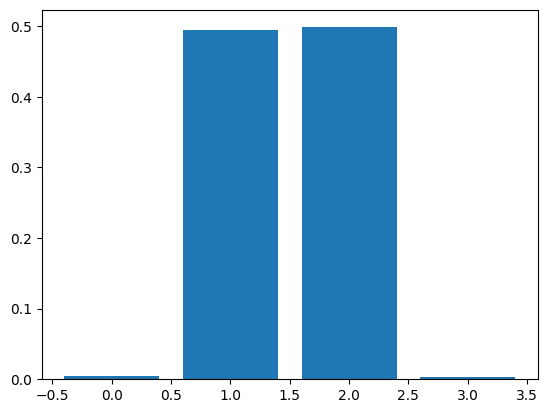

In [ ]:
output = qaoa(H, optimal_params[:2], optimal_params[2:])
plt.bar(range(len(output)), output)

**Exercise 2** (advanced)

A technique to speed up the training is not to start with all the layers of the QAOA initially. The idea will be to start by training a first layer, then add the next layer and start training the new parameters. By repeating this process successively the trainings are usually faster but also more accurate. Look for the maximum energy of the Hamiltonian:

```python
H = qml.PauliZ(1) - 0.3 * qml.PauliZ(2) @ qml.PauliZ(3) + 0.4 * qml.PauliZ(0) @ qml.PauliZ(3) + qml.PauliZ(4) - 0.3 qml.PauliZ(3) @ qml.PauliZ(4)
```

using this technique.



## First Solution

**Note**: This is a robust solution.  It correctly initializes parameters for each layer, and iterates correctly, updating the parameters for each layer during the layer-wise training.

In [ ]:
import pennylane as qml
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# Nuevo Hamiltoniano
H = (
    qml.PauliZ(1)
    - 0.3 * qml.PauliZ(2) @ qml.PauliZ(3)
    + 0.4 * qml.PauliZ(0) @ qml.PauliZ(3)
    + qml.PauliZ(4)
    - 0.3 * qml.PauliZ(3) @ qml.PauliZ(4)
)

In [ ]:
def exp(H, gamma):
    qml.ApproxTimeEvolution(H, gamma, n=1)

def mixer(beta, wires):
    for i in wires:
        qml.RX(2 * beta, wires=i)


In [ ]:
wires = list(range(5))
dev = qml.device("default.qubit", wires=wires)

def qaoa_circuit(H, gammas, betas):
    @qml.qnode(dev)
    def circuit():
        for i in wires:
            qml.Hadamard(wires=i)
        for gamma, beta in zip(gammas, betas):
            exp(H, gamma)
            mixer(beta, wires)
        return qml.expval(H)
    return circuit()


In [ ]:
def layerwise_qaoa(H, max_layers):
    params = []

    for p in range(1, max_layers + 1):
        if p == 1:
            init_params = np.random.uniform(0, np.pi, size=2)
        else:
            # Inicializa con los valores anteriores más uno nuevo
            init_params = np.append(params, np.random.uniform(0, np.pi, size=2))

        def cost(packed_params):
            gammas = packed_params[:p]
            betas = packed_params[p:]
            return -qaoa_circuit(H, gammas, betas)

        opt = minimize(cost, init_params, method="COBYLA")
        params = opt.x

        energy = qaoa_circuit(H, params[:p], params[p:])
        print(f"Capa {p}: energía máxima aproximada = {energy:.5f}")

    return params


In [ ]:
optimal_params = layerwise_qaoa(H, max_layers=3)


Capa 1: energía máxima aproximada = 2.02205
Capa 2: energía máxima aproximada = 2.07336
Capa 3: energía máxima aproximada = 1.95564


## Second Solution

This code is the most accurate and well-structured among the three.  It follows the layer-wise training approach correctly and demonstrates a deeper understanding of the problem. It initializes correctly, optimizes parameters layer by layer, and then evaluates the results.  It also includes a visualization of the probabilities of different final states.

This solution provides the most accurate and well-structured approach to the problem.

Training with p = 1 layers
Optimal parameters for p=1: [0.76440525 0.62482653]
Maximum energy found: 2.0220469218303396

Training with p = 2 layers
Optimal parameters for p=2: [0.35854305 0.89985559 0.89818807 0.44292978]
Maximum energy found: 2.280575939518346

Training with p = 3 layers
Optimal parameters for p=3: [0.47291721 0.95832285 1.47888652 0.93412903 0.54020918 0.23997275]
Maximum energy found: 2.5170163890501893



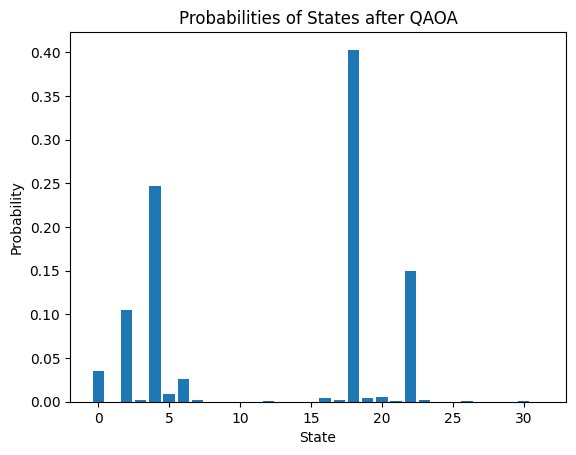

Maximum energy achieved: 2.5170163890501893


In [ ]:
import pennylane as qml
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the Hamiltonian
H = qml.PauliZ(1) - 0.3 * qml.PauliZ(2) @ qml.PauliZ(3) + 0.4 * qml.PauliZ(0) @ qml.PauliZ(3) + qml.PauliZ(4) - 0.3 * qml.PauliZ(3) @ qml.PauliZ(4)

def exp(H, gamma):
    qml.ApproxTimeEvolution(H, gamma, n=1)

def mixer(beta, wires):
    for w in wires:
        qml.RX(2 * beta, wires=w)

# Setup the device
num_qubits = 5
dev = qml.device("default.qubit", wires=num_qubits)

def value_solution(params):
    p = len(params) // 2
    gammas = params[:p]
    betas = params[p:]

    @qml.qnode(dev)
    def qaoa_circuit():
        # Apply Hadamard to all qubits
        for i in range(num_qubits):
            qml.Hadamard(wires=i)

        # Apply each layer
        for gamma, beta in zip(gammas, betas):
            exp(H, gamma)
            mixer(beta, wires=range(num_qubits))

        return qml.expval(H)

    return qaoa_circuit()

def cost(params):
    return -value_solution(params)

# Layer-wise training
max_layers = 3
optimal_params = None

for p in range(1, max_layers + 1):
    print(f"Training with p = {p} layers")

    # Initialize parameters
    if optimal_params is None:
        # Starting with p=1 layer, initial parameters
        initial_params = [0.3, 0.2]  # gamma1, beta1
    else:
        # Append new gamma and beta for the new layer
        initial_params = optimal_params.tolist() + [0.1, 0.1]  # Example initialization

    # Optimize
    sol = minimize(cost, initial_params, method="COBYLA")
    optimal_params = sol.x

    print(f"Optimal parameters for p={p}: {optimal_params}")
    print(f"Maximum energy found: {-sol.fun}\n")

# After training, get the probabilities with the optimal parameters
@qml.qnode(dev)
def qaoa_probabilities(params):
    p = len(params) // 2
    gammas = params[:p]
    betas = params[p:]

    for i in range(num_qubits):
        qml.Hadamard(wires=i)

    for gamma, beta in zip(gammas, betas):
        exp(H, gamma)
        mixer(beta, wires=range(num_qubits))

    return qml.probs(wires=range(num_qubits))

probs = qaoa_probabilities(optimal_params)

# Plot the probabilities
plt.bar(range(len(probs)), probs)
plt.xlabel('State')
plt.ylabel('Probability')
plt.title('Probabilities of States after QAOA')
plt.show()

# Print the maximum energy
print("Maximum energy achieved:", -cost(optimal_params))